In [ ]:
import pandas as pd
import torch
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from dl_biology.cafa6.training import generate_dataloader
from dl_biology.cafa6.helper import get_csr_matrix_from_terms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from dl_biology.cafa6.vanilla_models import NeuralNet
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# filepaths to fasta
path_to_hidden_embedding = "/Users/tungvuduc/Desktop/PhD/projects/repos/Deep-learning-for-biology/data/kaggle/cafa-6-protein-function-prediction/train_hidden_states/esm2_t6_8M_UR50D.h5"

# filepath to GO terms
path_to_go_term_train = "/Users/tungvuduc/Desktop/PhD/projects/repos/Deep-learning-for-biology/data/kaggle/cafa-6-protein-function-prediction/Train/train_terms.tsv"
path_term_weights = "/Users/tungvuduc/Desktop/PhD/projects/repos/Deep-learning-for-biology/data/kaggle/cafa-6-protein-function-prediction/IA.tsv"
term_weights = pd.read_csv(path_term_weights, delimiter="\t", header=None)


In [ ]:
def collate_fn(batch):
    # batch is a list of dicts
    embeds = [item["embedding"] for item in batch]
    seq_lengths = [item["seq_len"] for item in batch]
    labels = [item["label"] for item in batch]

    embeds_padded = pad_sequence(embeds, padding_value=0, batch_first=True)
    seq_lengths = torch.tensor(seq_lengths)
    labels = torch.stack(labels) if isinstance(labels[0], torch.Tensor) else torch.tensor(labels)
    max_len = embeds_padded.size(1)
    attention_mask = torch.arange(max_len).unsqueeze(0) < seq_lengths.unsqueeze(-1)
    
    return {
        "embedding": embeds_padded,
        "label": labels,
        "attn_mask": attention_mask
    }


In [94]:
# create train and val dataloader
train_terms = pd.read_csv(path_to_go_term_train, delimiter="\t")

train_terms_C = train_terms[train_terms["aspect"] == "C"]
train_terms_F = train_terms[train_terms["aspect"] == "F"]
train_terms_P = train_terms[train_terms["aspect"] == "P"]

seq_ids_C = (train_terms_C["EntryID"].unique())[:10000]
label_data_C, entry_labels_C, term_labels_C = get_csr_matrix_from_terms(train_terms_C)
label_data_F, entry_labels_F, term_labels_F = get_csr_matrix_from_terms(train_terms_F)
label_data_P, entry_labels_P, term_labels_P = get_csr_matrix_from_terms(train_terms_P)

train_idx_C, val_idx_C = train_test_split(
    np.arange(len(seq_ids_C)),
    test_size=0.1,
    random_state=42,
    shuffle=True
)

train_seq_ids_C = [seq_ids_C[idx] for idx in train_idx_C]
val_seq_ids_C = [seq_ids_C[idx] for idx in val_idx_C]

train_dataloader_C, val_dataloader_C = generate_dataloader(label_data_C, entry_labels_C, path_to_hidden_embedding, train_seq_ids_C, val_seq_ids_C, collate_fn, batch_size=32)

In [102]:
n_epochs = 5
embedding_size = 320
dropout = 0.1
out_dim = 2651
lr = 0.001
filtered_weights = term_weights.set_index(0).loc[term_labels_C, 1].values
weights_tensor = torch.tensor(filtered_weights, dtype=torch.float32)
model = NeuralNet(embedding_size=embedding_size, dropout=dropout, out_dim=out_dim)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    for batch in tqdm(train_dataloader_C):
        embedding = batch["embedding"]
        attn_mask = batch["attn_mask"]
        label = batch["label"]

        model.train()
        output = model(embedding, attn_mask)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss
    
    train_loss /= len(train_dataloader_C)
    train_losses.append(train_loss.item())

    outputs = []
    for batch in tqdm(val_dataloader_C):

        with torch.no_grad():
            model.eval()
            embedding = batch["embedding"]
            attn_mask = batch["attn_mask"]
            label = batch["label"]

            output = model(embedding, attn_mask)
            loss = criterion(output, label)

            val_loss += loss

    val_loss /= len(val_dataloader_C)
    val_losses.append(val_loss.item())

    print(f"Epoch {epoch} ===== train loss: {train_loss} ===== val loss: {val_loss}")

plt.plot([loss for loss in train_losses])
plt.plot([loss for loss in val_losses])


100%|██████████| 32/32 [00:03<00:00,  9.04it/s]


Epoch 0 ===== train loss: 0.03173261880874634 ===== val loss: 0.00728625850751996


100%|██████████| 32/32 [00:03<00:00,  9.46it/s]


Epoch 1 ===== train loss: 0.0076791951432824135 ===== val loss: 0.007027616258710623


100%|██████████| 32/32 [00:03<00:00,  9.58it/s]


Epoch 2 ===== train loss: 0.007224852219223976 ===== val loss: 0.006824944168329239


100%|██████████| 32/32 [00:03<00:00,  9.40it/s]


Epoch 3 ===== train loss: 0.006813029758632183 ===== val loss: 0.006719642784446478


100%|██████████| 32/32 [00:03<00:00,  9.43it/s]

Epoch 4 ===== train loss: 0.006454011425375938 ===== val loss: 0.0067178914323449135


In [105]:
outputs = []
for batch in tqdm(val_dataloader_C):

    with torch.no_grad():
        model.eval()
        embedding = batch["embedding"]
        attn_mask = batch["attn_mask"]
        label = batch["label"]

        output = model(embedding, attn_mask)
        output = torch.nn.Sigmoid()(output).detach().numpy()
        outputs.append(output)

100%|██████████| 32/32 [00:03<00:00,  9.37it/s]


0.13583740674041678


(array([2.645379e+06, 3.100000e+03, 9.180000e+02, 5.230000e+02,
        3.900000e+02, 3.210000e+02, 2.010000e+02, 1.210000e+02,
        3.600000e+01, 1.100000e+01]),
 array([2.32396883e-16, 9.48186070e-02, 1.89637214e-01, 2.84455836e-01,
        3.79274428e-01, 4.74093020e-01, 5.68911672e-01, 6.63730264e-01,
        7.58548856e-01, 8.53367448e-01, 9.48186100e-01]),
 <BarContainer object of 10 artists>)

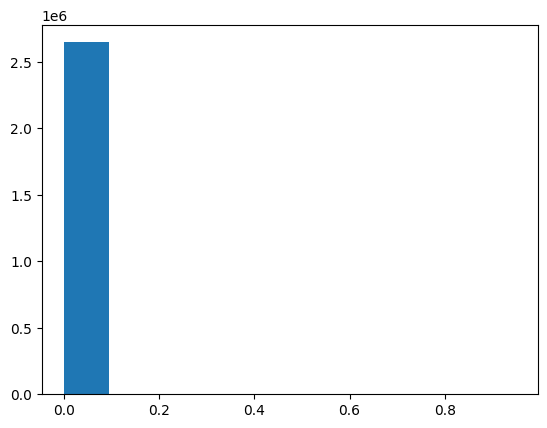

In [109]:
from sklearn.metrics import precision_score

# Calculate multi-label precision score (micro-averaged)
from sklearn.metrics import f1_score

y_pred = (np.concatenate(outputs) > 0.1).astype(int)
y_true = label_data_C[val_idx_C]
print(f1_score(y_true, y_pred, average="micro"))


plt.hist(np.concatenate(outputs).flatten())